In [ ]:
import zipfile
import os

# Unzip the dataset
zip_file = '/content/GMM-Speaker-Identification-data.zip'
output_dir = 'GMM-Speaker-Identification-data'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# Define paths for training and testing data
train_dir = "/content/GMM-Speaker-Identification-data/GMM-Speaker-Identification-data/Speaker_data/Voice_Samples_Training"
test_dir = "/content/GMM-Speaker-Identification-data/GMM-Speaker-Identification-data/Speaker_data/Testing_Audio"


In [ ]:
# Function to load audio files
def get_audio_files(data_dir):
    speakers = os.listdir(data_dir)  # List of speaker folders
    audio_files = {}

    for speaker in speakers:
        speaker_folder = os.path.join(data_dir, speaker)
        if os.path.isdir(speaker_folder):
            audio_files[speaker] = [os.path.join(speaker_folder, file)
                                    for file in os.listdir(speaker_folder) if file.endswith('.wav')]
    return audio_files

# Load training and testing data
train_files = get_audio_files(train_dir)
test_files = get_audio_files(test_dir)

# Check loaded data
print("Training files:", train_files)
print("Testing files:", test_files)


Training files: {'Abhay-001': ['/content/GMM-Speaker-Identification-data/GMM-Speaker-Identification-data/Speaker_data/Voice_Samples_Training/Abhay-001/Abhay_1.wav', '/content/GMM-Speaker-Identification-data/GMM-Speaker-Identification-data/Speaker_data/Voice_Samples_Training/Abhay-001/Abhay_5.wav', '/content/GMM-Speaker-Identification-data/GMM-Speaker-Identification-data/Speaker_data/Voice_Samples_Training/Abhay-001/Abhay_2.wav', '/content/GMM-Speaker-Identification-data/GMM-Speaker-Identification-data/Speaker_data/Voice_Samples_Training/Abhay-001/Abhay_3.wav', '/content/GMM-Speaker-Identification-data/GMM-Speaker-Identification-data/Speaker_data/Voice_Samples_Training/Abhay-001/Abhay_4.wav'], 'ShivamY-006': ['/content/GMM-Speaker-Identification-data/GMM-Speaker-Identification-data/Speaker_data/Voice_Samples_Training/ShivamY-006/chappu_1.wav', '/content/GMM-Speaker-Identification-data/GMM-Speaker-Identification-data/Speaker_data/Voice_Samples_Training/ShivamY-006/chappu_4.wav', '/conten

In [ ]:
def average_mfcc(mfcc_list):
    return [np.mean(mfcc, axis=1) for mfcc in mfcc_list]

In [ ]:
import numpy as np
import librosa

# Function to pad or truncate MFCCs to a fixed length
def pad_or_truncate(mfcc, target_length):
    if mfcc.shape[1] < target_length:
        # Pad with zeros if the mfcc has fewer frames than target
        return np.pad(mfcc, ((0, 0), (0, target_length - mfcc.shape[1])), mode='constant')
    else:
        # Truncate if it has more frames than target
        return mfcc[:, :target_length]

# Function to average MFCC features
def average_mfcc(mfcc_list, target_length):
    # Average MFCC features and ensure the target length
    averaged_mfccs = []
    for mfcc in mfcc_list:
        if mfcc.ndim == 2:  # Check if the MFCC is 2D
            mfcc_mean = np.mean(mfcc, axis=1)  # Average over time
        elif mfcc.ndim == 1:  # If it's 1D, just take it as is
            mfcc_mean = mfcc
        else:
            raise ValueError("Unexpected MFCC shape.")

        averaged_mfccs.append(mfcc_mean)

    # Stack the averaged MFCCs
    averaged_mfccs = np.array(averaged_mfccs)

    # Pad or trim the results to target length
    if averaged_mfccs.shape[1] < target_length:
        padded_mfcc = np.pad(averaged_mfccs, ((0, 0), (0, target_length - averaged_mfccs.shape[1])), mode='constant')
    else:
        padded_mfcc = averaged_mfccs[:, :target_length]

    return padded_mfcc

def extract_mfcc_with_delta(file_path, n_mfcc=13):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    # Concatenate MFCC, delta, and delta-delta features
    mfcc_combined = np.vstack([mfcc, mfcc_delta, mfcc_delta2])  # Shape should be (39, n_frames)
    return mfcc_combined


# Example usage for training data
train_mfcc = {}
target_length = 496  # or whatever the expected length is
for speaker, files in train_files.items():
    mfcc_features = [extract_mfcc_with_delta(f) for f in files]
    train_mfcc[speaker] = average_mfcc(mfcc_features, target_length)


# Check the new shape of MFCC features for one speaker
print(f"New MFCC shape for {list(train_mfcc.keys())[0]}: {train_mfcc[list(train_mfcc.keys())[0]].shape}")


New MFCC shape for Abhay-001: (5, 496)


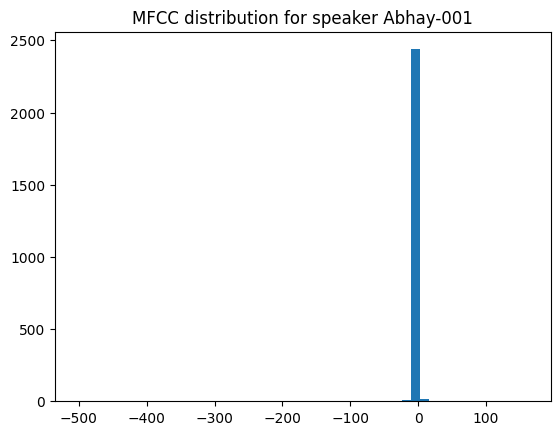

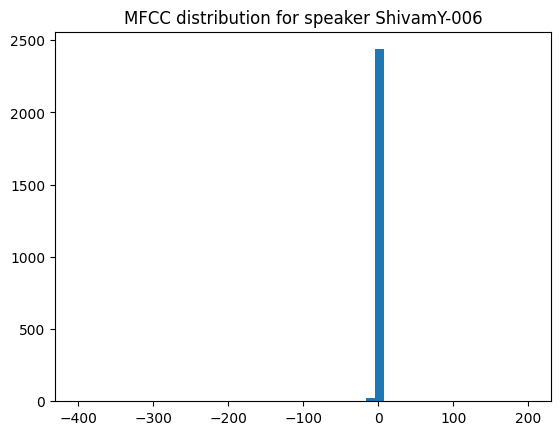

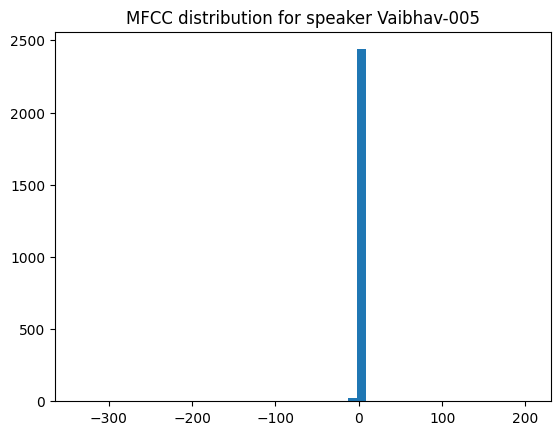

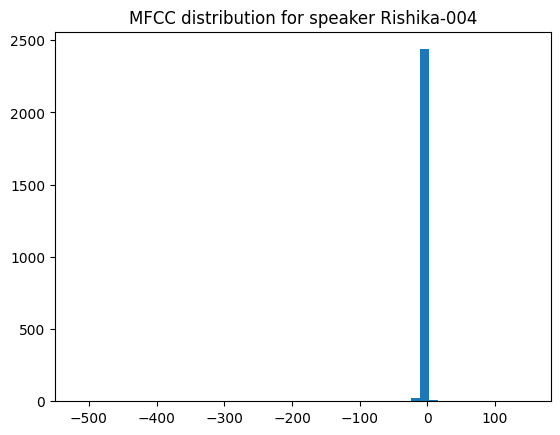

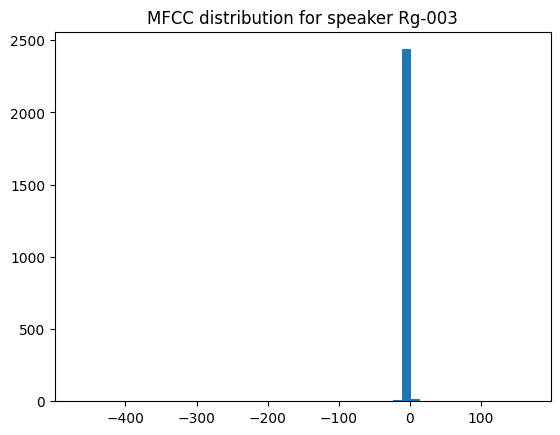

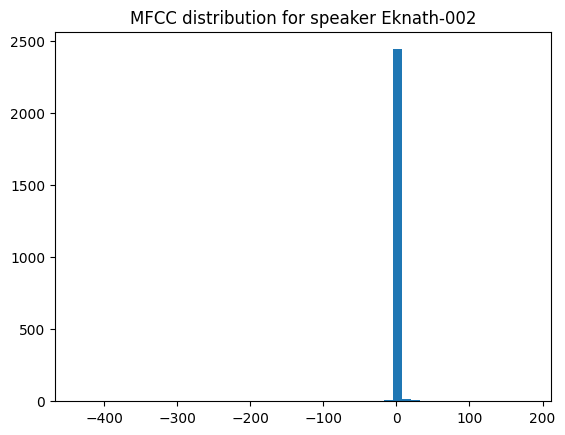

In [ ]:
import matplotlib.pyplot as plt
for speaker, mfcc_data in train_mfcc.items():
    plt.hist(mfcc_data.flatten(), bins=50)
    plt.title(f'MFCC distribution for speaker {speaker}')
    plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture

# Dictionary to store GMM models for each speaker
gmm_models = {}

# Train GMM for each speaker
for speaker, mfcc_data in train_mfcc.items():
    print(f"Training GMM for speaker: {speaker}, MFCC shape: {mfcc_data.shape}")  # Debugging info

    # Use fewer components and increase regularization
    n_components = min(2, mfcc_data.shape[0])  # Ensure n_components does not exceed number of samples
    gmm = GaussianMixture(n_components=n_components, max_iter=200, covariance_type='diag', n_init=3, reg_covar=1e-1)

    try:
        gmm.fit(mfcc_data)
        gmm_models[speaker] = gmm
        print(f"Successfully trained GMM for {speaker}.")
    except ValueError as e:
        print(f"Failed to train GMM for {speaker}: {e}")
        print(f"MFCC data for {speaker} (sample): {mfcc_data[:5]}")  # Log some sample MFCC data

print("GMM models training completed.")


Training GMM for speaker: Abhay-001, MFCC shape: (5, 496)
Successfully trained GMM for Abhay-001.
Training GMM for speaker: ShivamY-006, MFCC shape: (5, 496)
Successfully trained GMM for ShivamY-006.
Training GMM for speaker: Vaibhav-005, MFCC shape: (5, 496)
Successfully trained GMM for Vaibhav-005.
Training GMM for speaker: Rishika-004, MFCC shape: (5, 496)
Successfully trained GMM for Rishika-004.
Training GMM for speaker: Rg-003, MFCC shape: (5, 496)
Successfully trained GMM for Rg-003.
Training GMM for speaker: Eknath-002, MFCC shape: (5, 496)
Successfully trained GMM for Eknath-002.
GMM models training completed.


In [ ]:
def predict_speaker(test_file, gmm_models, target_length=496):
    mfcc_features = extract_mfcc_with_delta(test_file)
    mfcc_mean = average_mfcc(mfcc_features, target_length)

    # Make sure mfcc_mean is 2D before scoring
    if mfcc_mean.ndim == 1:
        mfcc_mean = mfcc_mean.reshape(1, -1)  # Reshape to (1, target_length)

    # Compute log likelihood for each speaker's GMM
    scores = {speaker: gmm.score(mfcc_mean) for speaker, gmm in gmm_models.items()}
    predicted_speaker = max(scores, key=scores.get)
    return predicted_speaker


# Predict speaker for each test file and evaluate
correct = 0
total = 0

for speaker, files in test_files.items():
    for test_file in files:
        predicted_speaker = predict_speaker(test_file, gmm_models)
        if predicted_speaker == speaker:
            correct += 1
        total += 1

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 0.00%
